In [3]:
import umap
import umap.plot
from umap import UMAP

import sklearn.datasets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import squareform, pdist
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Section 1.  **t-SNE, UMAP and LargeVis**

In this and the next notebook we will use manifold learning for data visualization of large data sets (with high dimensionality). In addition to t-SNE, two relatively new methods will be used that are more efficient on large data sets.


- UMAP (Uniform Manifold Approximation and Projection) - Install this Python package: https://umap-learn.readthedocs.io/en/latest/index.html. UMAP package is compatible with scikit-learn, making use of the same API and able to be added to sklearn pipelines. UMAP can work as a drop in replacement for t-SNE and other dimension reduction classes from scikit-learn


- LargeVis (Visualizing Large-scale and High-dimensional Data) - Many techniques (like t-SNE, UMAP and LargeVis) first compute a similarity structure of the data points and then project them into a low-dimensional space with the structure preserved. These two steps suffer from considerable computational costs Comparing to tSNE, LargeVis significantly reduces the computational cost of the graph construction step and employs a principled probabilistic model for the visualization step, the objective of which can be effectively optimized through asynchronous stochastic gradient descent with a linear time complexity. Download this algorithm repository and follow the installation instructions. https://github.com/lferry007/LargeVis


### Familiarise with UMAP - usefull links from documentation 

In [4]:
# https://umap-learn.readthedocs.io/en/latest/basic_usage.html
# https://umap-learn.readthedocs.io/en/latest/parameters.html
# https://umap-learn.readthedocs.io/en/latest/plotting.html

### MNIST and f-MNIST - fetch data and visualize images

To get data we use the sklearn.datasets.fetch_openml method, which as the name requires, Fetch dataset from openml by name or dataset id. We will use MNIST and Fashion-MNIST(Zalando's article images). Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. Instead of numbers it contains thumbnails of clothes images.

In [5]:
mnist = sklearn.datasets.fetch_openml('mnist_784')
fmnist = sklearn.datasets.fetch_openml('Fashion-MNIST')

Below are drawings of some samples from mnist and fmnist data sets

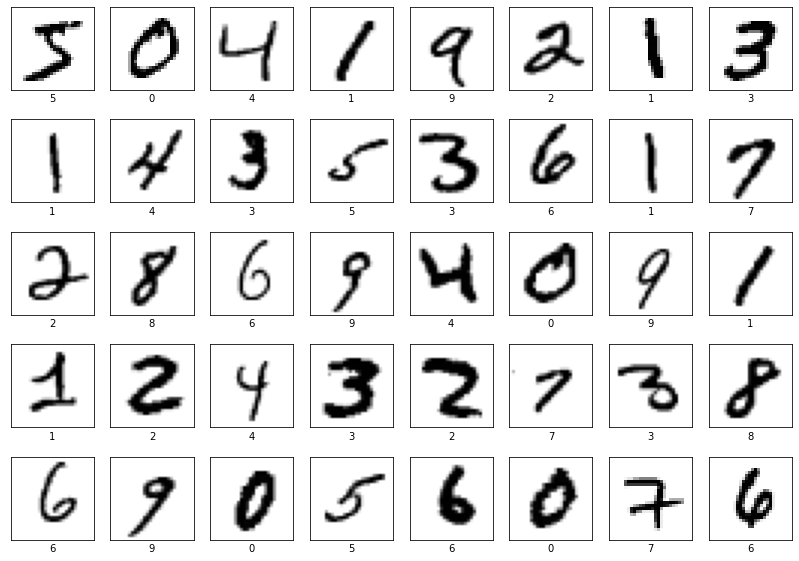

In [6]:
mnist_names = [i for i in range(10)]

plt.figure(figsize=(14,10))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.array(mnist.data.iloc[i]).reshape((28, 28)), cmap=plt.cm.binary)
    plt.xlabel(mnist_names[int(mnist.target[i])])
plt.show()

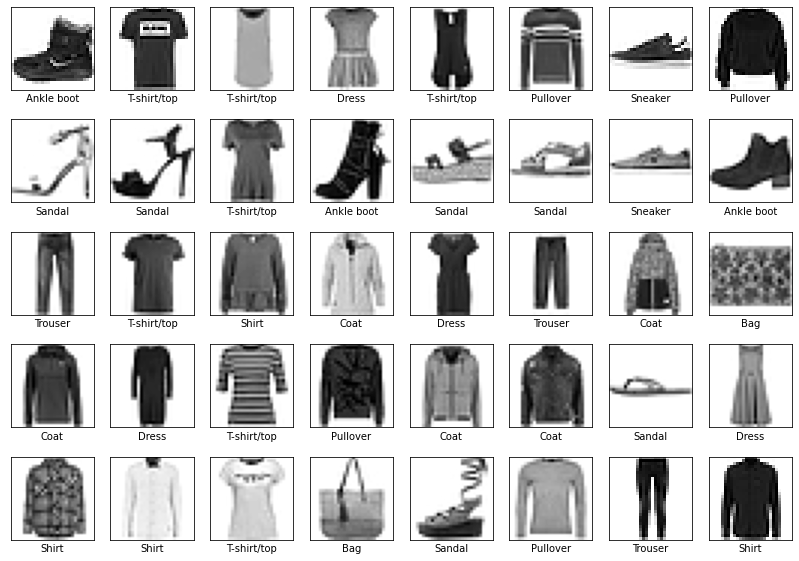

In [7]:
fmnist_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
 
plt.figure(figsize=(14,10))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.array(fmnist.data.iloc[i]).reshape((28, 28)), cmap=plt.cm.binary)
    plt.xlabel(fmnist_names[int(fmnist.target[i])])
plt.show()

#### Use t-SNE, UMAP and LargeVis to project mnist and fmnist data sets into a 2-dimensional space. For LargeVis, we need to create a function that saves the data to the required by LargeVis txt file format, and a function that loads the resulting file. Draw charts for all visualizations.

In [8]:
df_mnist = pd.DataFrame(data=mnist.data, columns=mnist.feature_names)
df_mnist['target'] = mnist.target

df_fmnist = pd.DataFrame(data=fmnist.data, columns=fmnist.feature_names)
df_fmnist['target'] = fmnist.target

In [9]:
print(f"Mnist dataset shape: {df_mnist.shape}")
X_mnist_data = df_mnist.iloc[:, :-1].values / 255.0
y_mnist_data = df_mnist.loc[:, 'target'].values

print(f"fashion-Mnist dataset shape: {df_mnist.shape}")
X_fmnist_data = df_fmnist.iloc[:, :-1].values / 255.0
y_fmnist_data = df_fmnist.loc[:, 'target'].values

Mnist dataset shape: (70000, 785)
fashion-Mnist dataset shape: (70000, 785)


**Conclusion**
<p align="justify">
There is no point to perform standarization. Each feature (column) in both datasets represents
single pixel. Each pixel has its value in same range. According to the definition of standarization
"Standardization is useful when your data has varying scales", that is why Standard Scaler will not be used. However, there is point to use normalization to operate on data values ranging from 0 to 1 instead of 0 to 255 (the maximum value for a given pixel).
</p>

## MNIST - embedding and visualizations

In [10]:
def plot_2d_mnist_scatter(X, y):
    fig, plot = plt.subplots()
    fig.set_size_inches(10, 10)
    plt.prism()

    for i in range(10): 
        digit_indices = (y == i)
        dim0 = X[digit_indices, 0]
        dim1 = X[digit_indices, 1]
        plot.scatter(dim0, dim1, label=f"Digit {i}")


    plot.set_xticks(())
    plot.set_yticks(())

    plt.tight_layout()
    plt.legend()
    plt.show()

### t-SNE porjection of MNIST

In [11]:
mnist_tsne_embedding = TSNE(n_components=2, perplexity=40).fit_transform(X_mnist_data)

### Visualization of t-SNE-embedded MNIST dataset

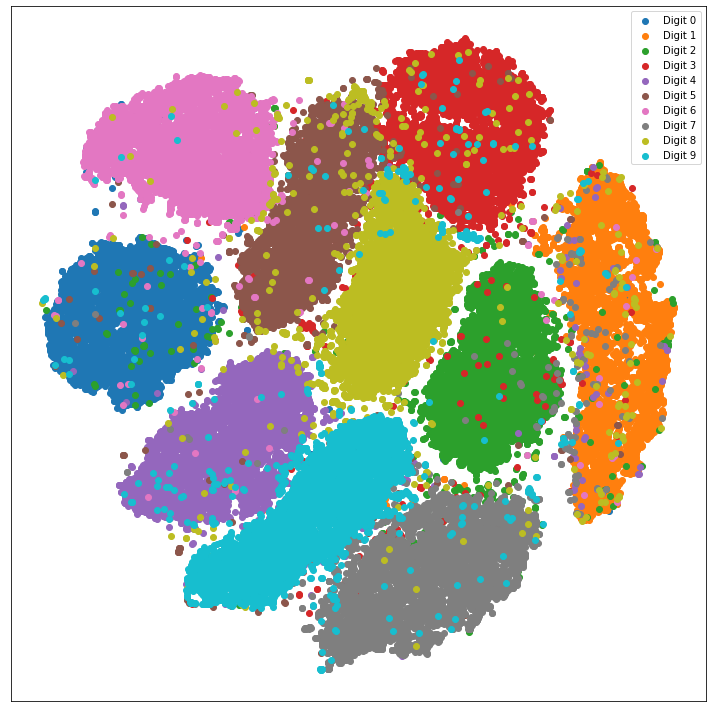

In [12]:
plot_2d_mnist_scatter(mnist_tsne_embedding, y_mnist_data.astype(int))

### UMAP projection of MNIST

In [13]:
mnist_umap_reducer = UMAP()
mnist_umap_embedding = mnist_umap_reducer.fit_transform(X_mnist_data)
mnist_umap_embedding.shape

(70000, 2)

### Visualization of UMAP-embedded MNIST dataset

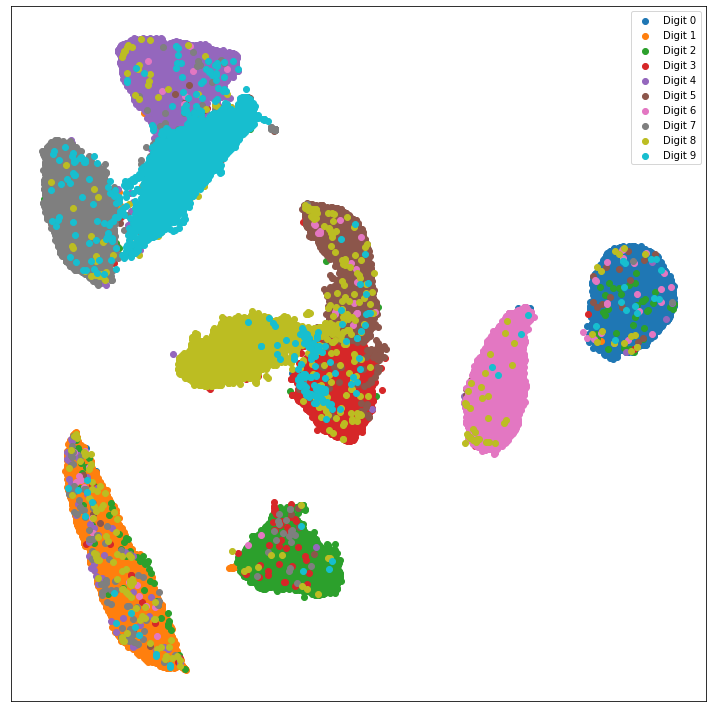

In [14]:
plot_2d_mnist_scatter(mnist_umap_embedding, y_mnist_data.astype(int))

### Visualization of UMAP-embedded MNIST dataset - alternatively, using umap.plot

<AxesSubplot:>

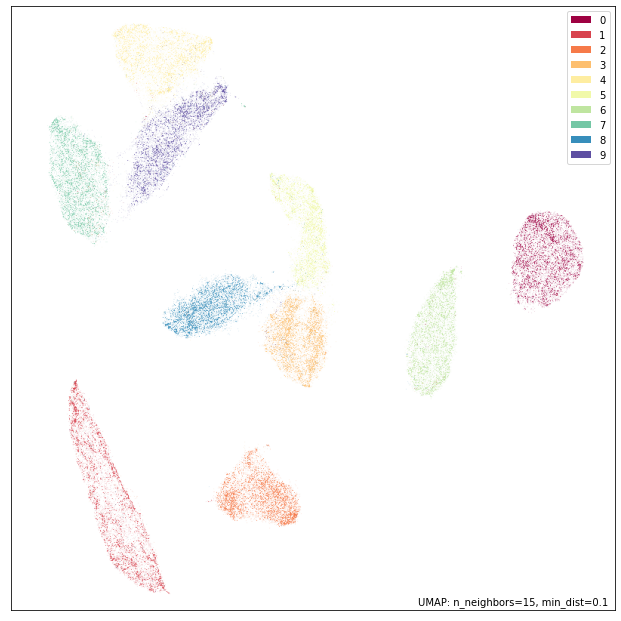

In [15]:
umap.plot.points(mnist_umap_reducer, labels=df_mnist.target)

### LargeVis projection of MNIST

In [21]:
df_mnist_largevis_embedding = pd.read_csv(
    './mnist_largevis_output.txt',
    sep=' ',
    header=0,
    names=['Component 1', 'Component 2'])

mnist_largevis_embedding = df_mnist_largevis_embedding.values
df_mnist_largevis_embedding.head()

,Component 1,Component 2
0,11.968012,6.044398
1,32.303223,2.512996
2,-27.399160,-17.749571
3,-22.922476,14.632609
4,-21.657269,-7.259162


### Visualization of LargeVis-embedded MNIST dataset

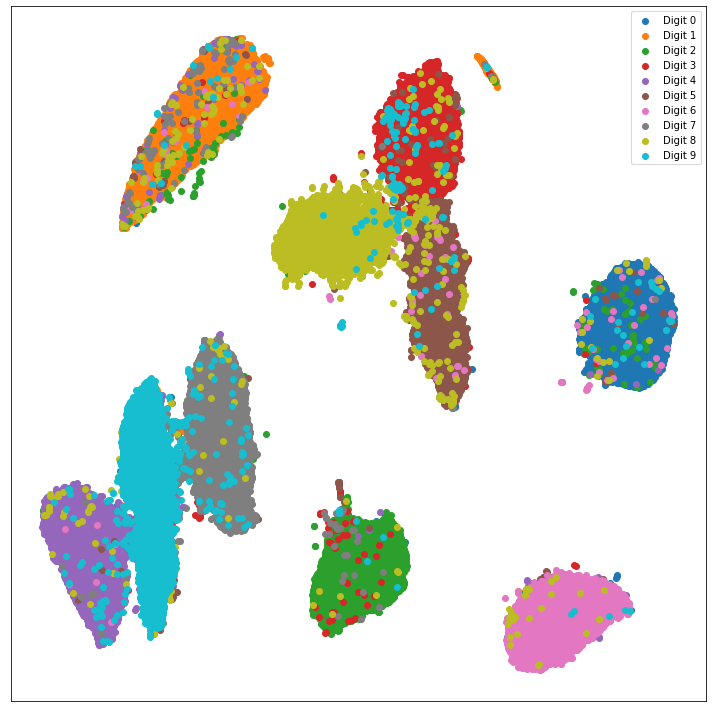

In [22]:
plot_2d_mnist_scatter(mnist_largevis_embedding, y_mnist_data.astype(int))

**Conclusions**

T-SNE allows for a reasonably decent separation. Having in mind two separation quality metrics - local and global, UMAP and Largevis seems to be really good. They not only great separate the data locally but also maintaint the global relation between clusters. For example, points that represents digit 9, 7 and 4 are located next to each other as they have a lot of similarities.

## fashion MNIST -  embedding and visualizations

In [23]:
fmnist_names_mapping = dict(zip(range(10), fmnist_names))
fmnist_names_mapping = {str(k):v for k, v in fmnist_names_mapping.items()}
fmnist_names_mapping

{'0': 'T-shirt/top',
 '1': 'Trouser',
 '2': 'Pullover',
 '3': 'Dress',
 '4': 'Coat',
 '5': 'Sandal',
 '6': 'Shirt',
 '7': 'Sneaker',
 '8': 'Bag',
 '9': 'Ankle boot'}

In [24]:
def plot_2d_fashion_mnist_scatter(X, y, labels):

    fig, plot = plt.subplots()
    fig.set_size_inches(10, 10)
    plt.prism()

    for i in range(len(labels)): 
        digit_indices = (y == i)
        dim0 = X[digit_indices, 0]
        dim1 = X[digit_indices, 1]
        plot.scatter(dim0, dim1, label=f"{labels[i]}")


    plot.set_xticks(())
    plot.set_yticks(())

    plt.tight_layout()
    plt.legend()
    plt.show()

### t-SNE projection of f-MNIST

In [25]:
fmnist_tsne_embedding = TSNE(n_components=2, perplexity=40).fit_transform(X_fmnist_data)

### Visualization of t-SNE-embedded f-MNIST dataset

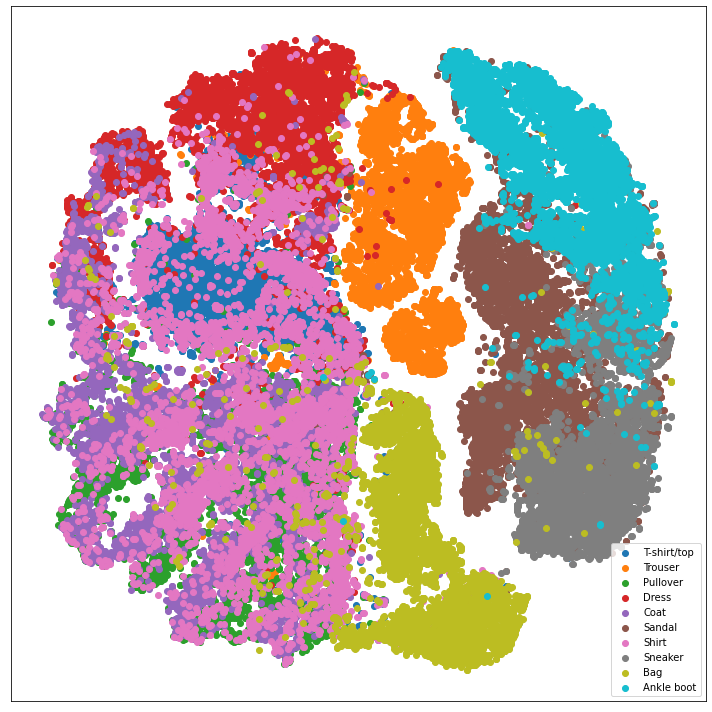

In [26]:
plot_2d_fashion_mnist_scatter(fmnist_tsne_embedding, y_fmnist_data.astype(int), fmnist_names)

### UMAP projection of f-MNIST

In [27]:
fmnist_umap_reducer = UMAP()
fmnist_umap_embedding = fmnist_umap_reducer.fit_transform(X_fmnist_data)
fmnist_umap_embedding.shape

(70000, 2)

### Visualization of UMAP-embedded f-MNIST dataset

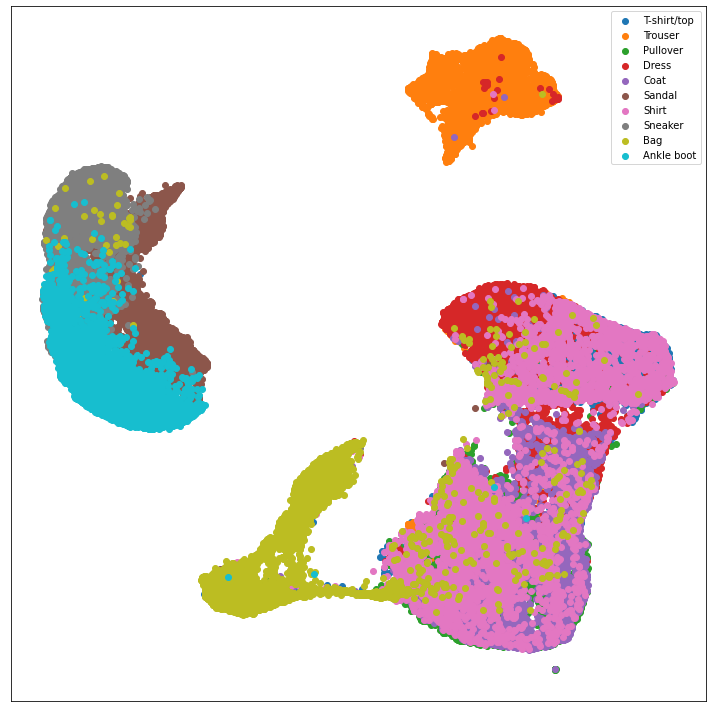

In [28]:
plot_2d_fashion_mnist_scatter(fmnist_umap_embedding, y_fmnist_data.astype(int), fmnist_names)

### Visualization of UMAP-embedded f-MNIST dataset - alternatively, using umap.plot

<AxesSubplot:>

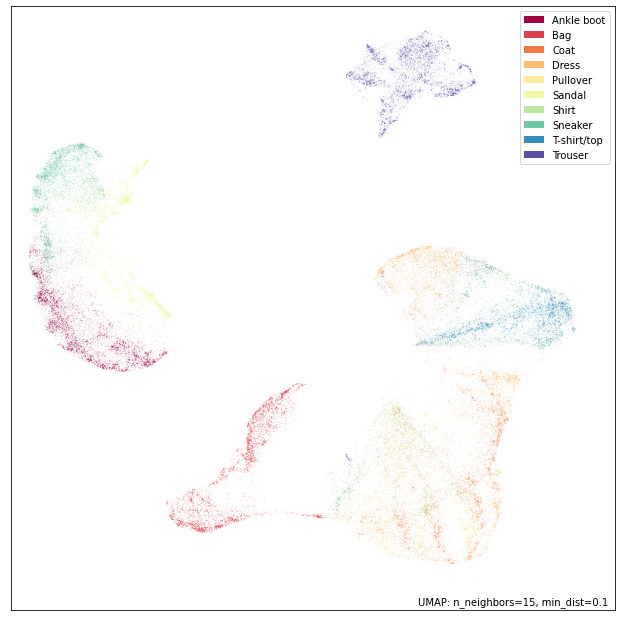

In [29]:
umap.plot.points(fmnist_umap_reducer, labels=df_fmnist.replace({'target': fmnist_names_mapping}).target)

### LargeVis projection of f-MNIST

In [30]:
df_fmnist_largevis_embedding = pd.read_csv(
    './fmnist_largevis_output.txt',
    sep=' ',
    header=0,
    names=['Component 1', 'Component 2'])

fmnist_largevis_embedding = df_fmnist_largevis_embedding.values
df_fmnist_largevis_embedding.head()

,Component 1,Component 2
0,12.631873,-22.384851
1,-17.051981,26.304689
2,-9.255348,14.999328
3,-7.707053,14.042500
4,-3.399491,15.376377


### Visualization of LargeVis-embedded f-MNIST dataset

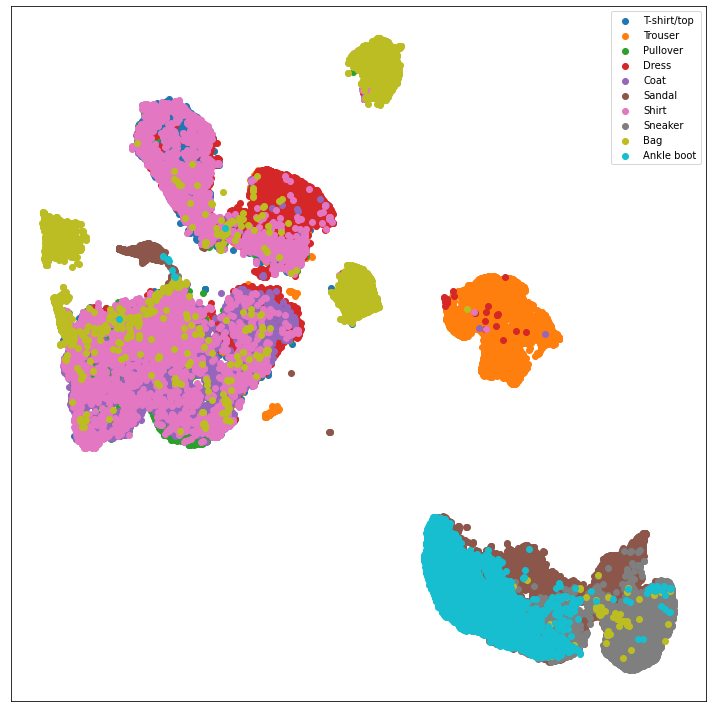

In [31]:
plot_2d_fashion_mnist_scatter(fmnist_largevis_embedding, y_fmnist_data.astype(int), fmnist_names)

**Conclusions**

Regarding f-MNIST, for each data embedding techniques, we can see a good separation (local and global) for Ankle boot, sneaker and sandal classes. Moreover, points that are related to the bag class are also well separated. Pure separation in the remaining classes seems to be quite problematic because clothing items such as a t-shirt, shirt, dress, coat have many similarities. 

# Section 2 - **Metrics**

#### In order to compare the results of these three embedding methods (t-SNE, UMAP and LargeVis), calculate for each case the average distance between two points belonging to the same class divided by the average distance between points belonging to different classes

In [32]:
import numba
import random

from scipy.spatial.distance import squareform, pdist
from sklearn.model_selection import train_test_split

markers = ["x", "o", "s", "*", "^", ".", "X"]
colors = ["red", "blue", "green", "brown", "orange", "cyan", "grey", "purple"]


@numba.jit(nopython=True)
def knngain(d_hd, d_ld, labels):
    # Number of data points
    N = d_hd.shape[0]
    N_1 = N - 1
    k_hd = np.zeros(shape=N_1, dtype=np.int64)
    k_ld = np.zeros(shape=N_1, dtype=np.int64)
    # For each data point
    for i in range(N):
        c_i = labels[i]
        di_hd = d_hd[i, :].argsort(kind="mergesort")
        di_ld = d_ld[i, :].argsort(kind="mergesort")
        # Making sure that i is first in di_hd and di_ld
        for arr in [di_hd, di_ld]:
            for idj, j in enumerate(arr):
                if j == i:
                    idi = idj
                    break
            if idi != 0:
                arr[idi] = arr[0]
            arr = arr[1:]
        for k in range(N_1):
            if c_i == labels[di_hd[k]]:
                k_hd[k] += 1
            if c_i == labels[di_ld[k]]:
                k_ld[k] += 1
    # Computing the KNN gain
    gn = (k_ld.cumsum() - k_hd.cumsum()).astype(np.float64) / (
        (1.0 + np.arange(N_1)) * N
    )
    # Returning the KNN gain and its AUC
    return gn, eval_auc(gn)


@numba.jit(nopython=True)
def eval_auc(arr):
    i_all_k = 1.0 / (np.arange(arr.size) + 1.0)
    return np.float64(arr.dot(i_all_k)) / (i_all_k.sum())


@numba.jit(nopython=True)
def eval_rnx(Q):
    N_1 = Q.shape[0]
    N = N_1 + 1
    # Computing Q_NX
    qnxk = np.empty(shape=N_1, dtype=np.float64)
    acc_q = 0.0
    for K in range(N_1):
        acc_q += Q[K, K] + np.sum(Q[K, :K]) + np.sum(Q[:K, K])
        qnxk[K] = acc_q / ((K + 1) * N)
    # Computing R_NX
    arr_K = np.arange(N_1)[1:].astype(np.float64)
    rnxk = (N_1 * qnxk[: N_1 - 1] - arr_K) / (N_1 - arr_K)
    # Returning
    return rnxk


def eval_dr_quality(d_hd, d_ld):
    # Computing the co-ranking matrix of the embedding, and the R_{NX}(K) curve.
    rnxk = eval_rnx(Q=coranking(d_hd=d_hd, d_ld=d_ld))
    # Computing the AUC, and returning.
    return rnxk, eval_auc(rnxk)


def coranking(d_hd, d_ld):
    # Computing the permutations to sort the rows of the distance matrices in HDS and LDS.
    perm_hd = d_hd.argsort(axis=-1, kind="mergesort")
    perm_ld = d_ld.argsort(axis=-1, kind="mergesort")

    N = d_hd.shape[0]
    i = np.arange(N, dtype=np.int64)
    # Computing the ranks in the LDS
    R = np.empty(shape=(N, N), dtype=np.int64)
    for j in range(N):
        R[perm_ld[j, i], j] = i
    # Computing the co-ranking matrix
    Q = np.zeros(shape=(N, N), dtype=np.int64)
    for j in range(N):
        Q[i, R[perm_hd[j, i], j]] += 1
    # Returning
    return Q[1:, 1:]


def viz_qa(
    Ly,
    ymin=None,
    ymax=None,
    Lmarkers=None,
    Lcols=None,
    Lleg=None,
    Lls=None,
    Lmedw=None,
    Lsdots=None,
    lw=2,
    markevery=0.1,
    tit="",
    folder_name="",
    xlabel="",
    ylabel="",
    alpha_plot=0.9,
    alpha_leg=0.8,
    stit=25,
    sax=20,
    sleg=15,
    zleg=1,
    loc_leg="best",
    ncol_leg=1,
    lMticks=10,
    lmticks=5,
    wMticks=2,
    wmticks=1,
    nyMticks=11,
    mymticks=4,
    grid=True,
    grid_ls="solid",
    grid_col="lightgrey",
    grid_alpha=0.7,
    xlog=True,
):
    # Number of curves
    nc = len(Ly)
    # Checking the parameters
    if ymin is None:
        ymin = np.min(np.asarray([arr.min() for arr in Ly]))
    if ymax is None:
        ymax = np.max(np.asarray([arr.max() for arr in Ly]))
    if Lmarkers is None:
        Lmarkers = ["x"] * nc
    if Lcols is None:
        Lcols = ["blue"] * nc
    if Lleg is None:
        Lleg = [None] * nc
        add_leg = False
    else:
        add_leg = True
    if Lls is None:
        Lls = ["solid"] * nc
    if Lmedw is None:
        Lmedw = [float(lw) / 2.0] * nc
    if Lsdots is None:
        Lsdots = [12] * nc

    # Setting the limits of the y-axis
    y_lim = [ymin, ymax]

    # Defining the ticks on the y-axis
    yMticks = np.linspace(
        start=ymin, stop=ymax, num=nyMticks, endpoint=True, retstep=False
    )
    ymticks = np.linspace(
        start=ymin,
        stop=ymax,
        num=1 + mymticks * (nyMticks - 1),
        endpoint=True,
        retstep=False,
    )
    yMticksLab = [int(round(v * 100.0)) / 100.0 for v in yMticks]

    # Initial values for xmin and xmax
    xmin, xmax = 1, -np.inf

    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111)
    if xlog:
        fplot = ax.semilogx
    else:
        fplot = ax.plot

    # Plotting the data
    for id, y in enumerate(Ly):
        x = np.arange(start=1, step=1, stop=y.size + 0.5, dtype=np.int64)
        xmax = max(xmax, x[-1])
        fplot(
            x,
            y,
            label=Lleg[id],
            alpha=alpha_plot,
            color=Lcols[id],
            linestyle=Lls[id],
            lw=lw,
            marker=Lmarkers[id],
            markeredgecolor=Lcols[id],
            markeredgewidth=Lmedw[id],
            markersize=Lsdots[id],
            dash_capstyle="round",
            solid_capstyle="round",
            dash_joinstyle="round",
            solid_joinstyle="round",
            markerfacecolor=Lcols[id],
            markevery=markevery,
        )

    # Setting the limits of the axes
    ax.set_xlim([xmin, xmax])
    ax.set_ylim(y_lim)

    # Setting the major and minor ticks on the y-axis
    ax.set_yticks(yMticks, minor=False)
    ax.set_yticks(ymticks, minor=True)
    ax.set_yticklabels(yMticksLab, minor=False, fontsize=sax)

    # Defining the legend
    if add_leg:
        leg = ax.legend(
            loc=loc_leg,
            fontsize=sleg,
            markerfirst=True,
            fancybox=True,
            framealpha=alpha_leg,
            ncol=ncol_leg,
        )
        if zleg is not None:
            leg.set_zorder(zleg)

    # Setting the size of the ticks labels on the x axis
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(sax)

    # Setting ticks length and width
    ax.tick_params(axis="both", length=lMticks, width=wMticks, which="major")
    ax.tick_params(axis="both", length=lmticks, width=wmticks, which="minor")

    # Setting the positions of the labels
    ax.xaxis.set_tick_params(labelright=False, labelleft=True)
    ax.yaxis.set_tick_params(labelright=False, labelleft=True)

    # Adding the grids
    if grid:
        ax.xaxis.grid(
            True, linestyle=grid_ls, which="major", color=grid_col, alpha=grid_alpha
        )
        ax.yaxis.grid(
            True, linestyle=grid_ls, which="major", color=grid_col, alpha=grid_alpha
        )
    ax.set_axisbelow(True)

    ax.set_title(tit, fontsize=stit)
    ax.set_xlabel(xlabel, fontsize=sax)
    ax.set_ylabel(ylabel, fontsize=sax)
    # plt.tight_layout()

    # Showing the figure
    fig.savefig(
        "./{}.png".format(
            tit
        ),
        dpi=fig.dpi,
    )


class LocalMetric:
    def __init__(self):
        self.L_rnx = []
        self.L_kg = []
        self.Lleg_rnx = []
        self.Lleg_kg = []
        self.Lls = []
        self.number_of_methods = 0

    def calculate_knn_gain_and_dr_quality(
        self,
        X_lds: np.ndarray,
        X_hds: np.ndarray,
        labels: np.ndarray,
        method_name: str,
    ):

        (
            X_hds_train,
            X_hds_test,
            X_lds_train,
            X_lds_test,
            labels_train,
            labels_test,
        ) = train_test_split(X_hds, X_lds, labels, test_size=0.15)

        print("Calculating d_hd")
        d_hd = squareform(X=pdist(X=X_hds_test, metric="euclidean"), force="tomatrix")

        print(method_name)
        d_ld = squareform(X=pdist(X=X_lds_test, metric="euclidean"), force="tomatrix")
        rnxk, auc_rnx = eval_dr_quality(d_hd=d_hd, d_ld=d_ld)
        kg, auc_kg = knngain(d_hd=d_hd, d_ld=d_ld, labels=labels_test)

        self.L_rnx.append(rnxk)
        self.L_kg.append(kg)
        self.Lleg_rnx.append(
            "{} {}".format(int(round(auc_rnx * 1000)) / 1000.0, method_name)
        )
        self.Lleg_kg.append(
            "{} {}".format(int(round(auc_kg * 1000)) / 1000.0, method_name)
        )
        self.Lls.append("solid")
        self.number_of_methods = self.number_of_methods + 1

    def visualize(self):
        Lmarkers = random.sample(markers, self.number_of_methods)
        Lcols = random.sample(colors, self.number_of_methods)
        Lmedw = [1.0] * self.number_of_methods
        Lsdots = [12] * self.number_of_methods

        viz_qa(
            Ly=self.L_rnx,
            Lmarkers=Lmarkers,
            Lcols=Lcols,
            Lleg=self.Lleg_rnx,
            Lls=self.Lls,
            Lmedw=Lmedw,
            Lsdots=Lsdots,
            tit="DR quality",
            xlabel="Neighborhood size $K$",
            ylabel="$R_{NX}(K)$",
        )

        viz_qa(
            Ly=self.L_kg,
            Lmarkers=Lmarkers,
            Lcols=Lcols,
            Lleg=self.Lleg_kg,
            Lls=self.Lls,
            Lmedw=Lmedw,
            Lsdots=Lsdots,
            tit="KNN gain",
            xlabel="Neighborhood size $K$",
            ylabel="$G_{NN}(K)$",
        )

        print("Finished.")

# ===============================        
# ============ USAGE ============      
# ===============================
#
# if __name__ == "__main__":
#     local_metrics = LocalMetric()
#
#     # embed dataset using some method (low-dimensional space)
#     X_embedded = method["object"].fit_transform(X)
#
#     # X.values is original dataset (high-dimensional space)
#     local_metrics.calculate_knn_gain_and_dr_quality(
#         X_lds=X_embedded,
#         X_hds=X.values,
#         labels=labels.values,
#         method_name="{} {}".format(dataset_name, method["name"]),
#     )

In [33]:
# instanciate object of LocalMetric class
local_metrics_mnist = LocalMetric()

In [34]:
# Calculate metric for MNIST dataset before and after t-SNE embedding.
local_metrics_mnist.calculate_knn_gain_and_dr_quality(
    X_lds=mnist_tsne_embedding, 
    X_hds=X_mnist_data,
    labels=np.array(y_mnist_data.astype(str).astype(int)),
    method_name='tsne')

Calculating d_hd
tsne


In [35]:
# Calculate metric for MNIST dataset before and after UMAP embedding.
local_metrics_mnist.calculate_knn_gain_and_dr_quality(
    X_lds=mnist_umap_embedding, 
    X_hds=X_mnist_data,
    labels=np.array(y_mnist_data.astype(str).astype(int)),
    method_name='umap')

Calculating d_hd
umap


Calculating d_hd
largevis
Finished.


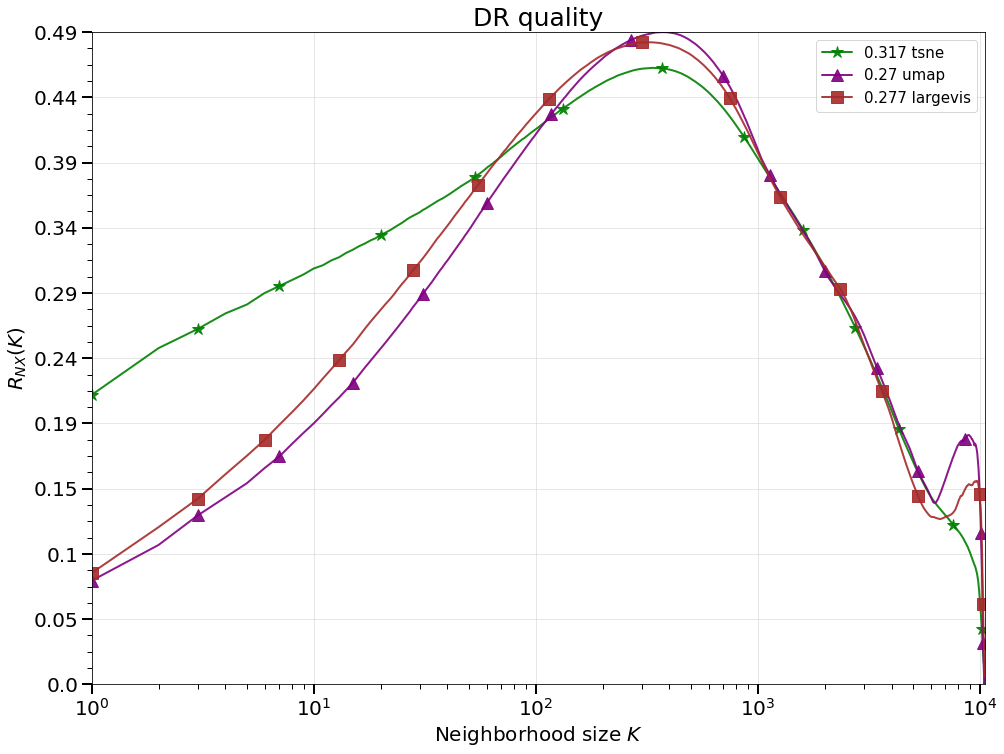

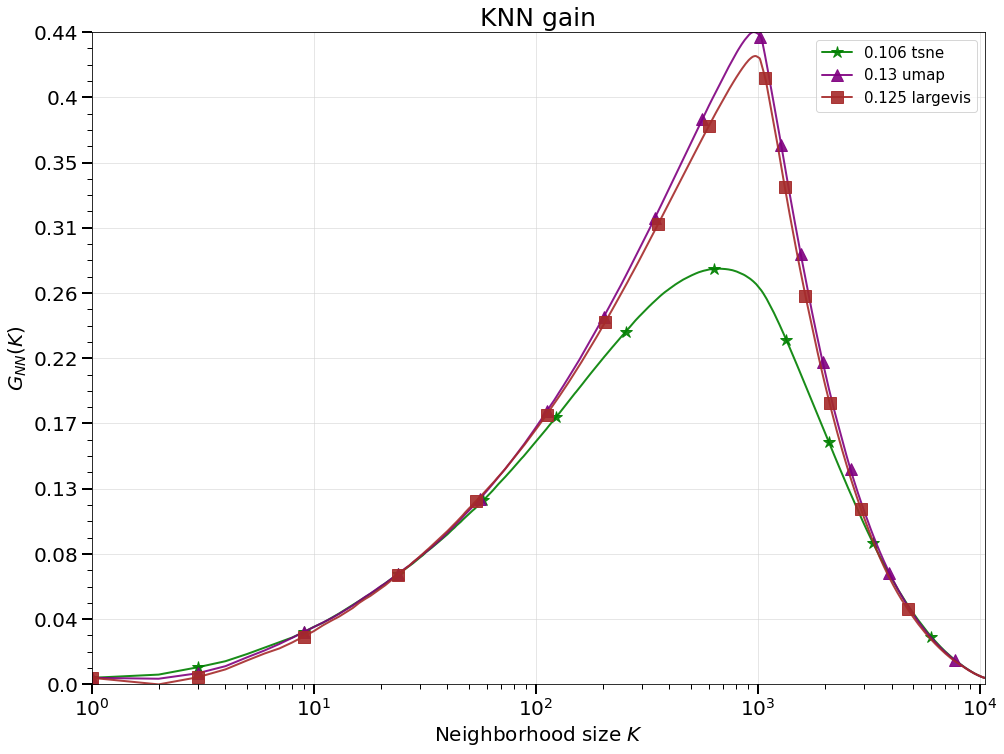

In [36]:
# Calculate metric for MNIST dataset before and after Largevis embedding.
local_metrics_mnist.calculate_knn_gain_and_dr_quality(
    X_lds=mnist_largevis_embedding, 
    X_hds=X_mnist_data,
    labels=np.array(y_mnist_data.astype(str).astype(int)),
    method_name='largevis')


# Visualise metrics
local_metrics_mnist.visualize()

In [57]:
# Calculate metric for f-MNIST dataset before and after t-SNE embedding.
local_metrics_fmnist = LocalMetric()

local_metrics_fmnist.calculate_knn_gain_and_dr_quality(
    X_lds=fmnist_tsne_embedding, 
    X_hds=X_fmnist_data,
    labels=np.array(y_fmnist_data.astype(str).astype(int)),
    method_name='tsne')

Calculating d_hd
tsne


In [58]:
# Calculate metric for f-MNIST dataset before and after UMAP embedding.
local_metrics_fmnist.calculate_knn_gain_and_dr_quality(
    X_lds=fmnist_umap_embedding, 
    X_hds=X_fmnist_data,
    labels=np.array(y_fmnist_data.astype(str).astype(int)),
    method_name='umap')

Calculating d_hd
umap


Calculating d_hd
largevis
Finished.


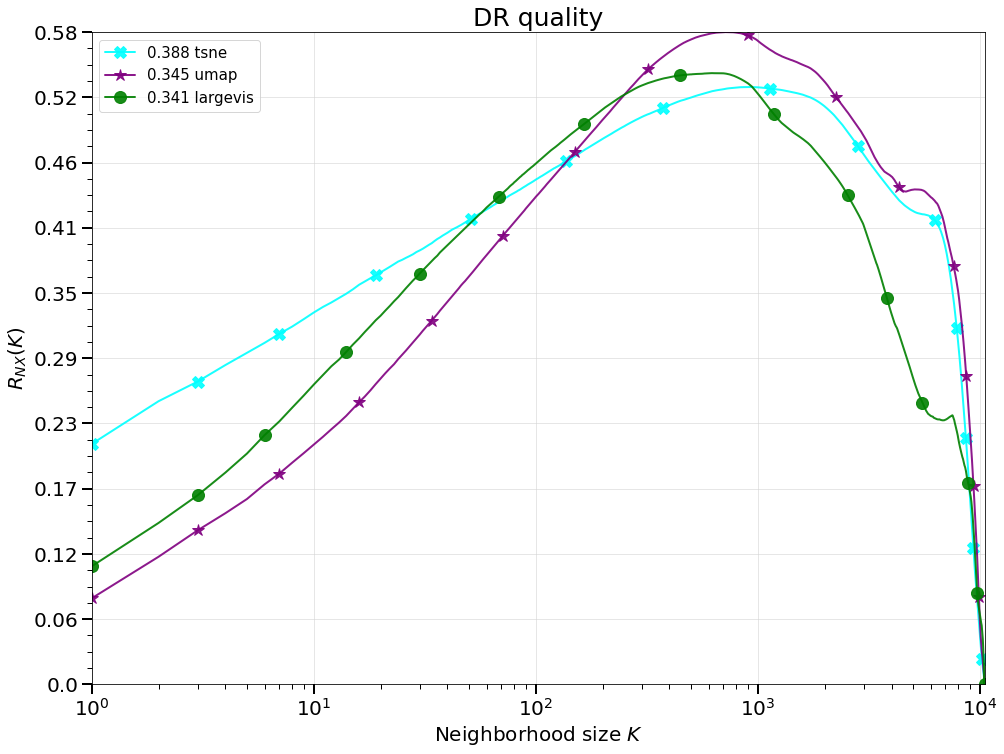

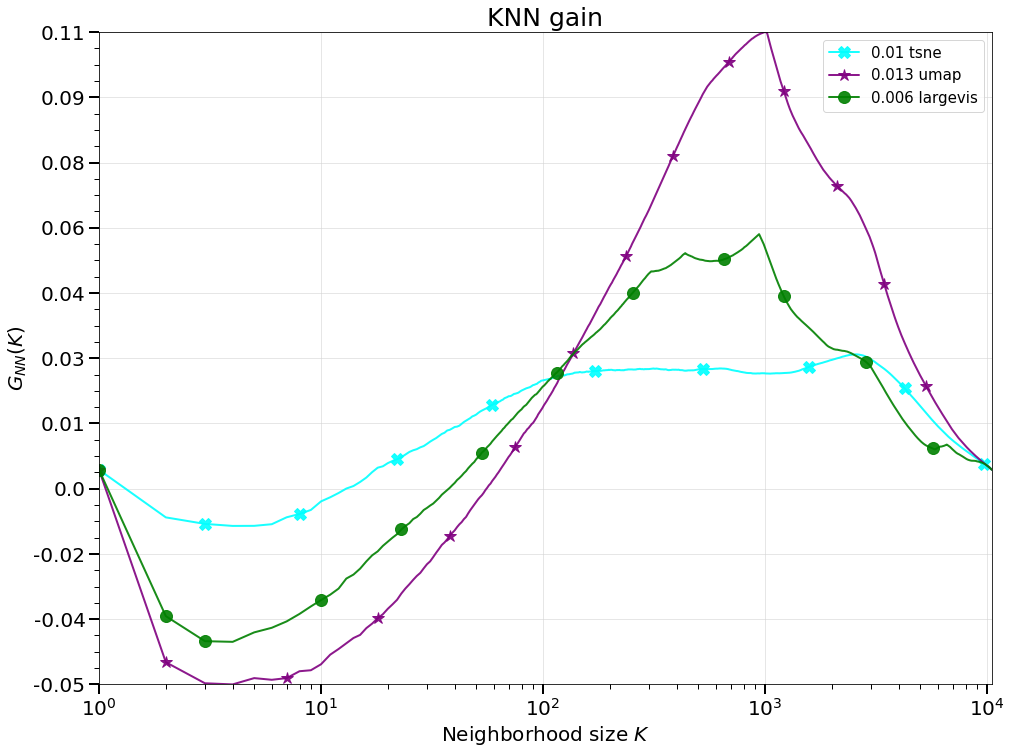

In [59]:
# Calculate metric for f-MNIST dataset before and after LargeVis embedding.
local_metrics_fmnist.calculate_knn_gain_and_dr_quality(
    X_lds=fmnist_largevis_embedding, 
    X_hds=X_fmnist_data,
    labels=np.array(y_fmnist_data.astype(str).astype(int)),
    method_name='largevis')

# Vizualize
local_metrics_fmnist.visualize()

**Conclusion**

In addition to determining the quality of embedding based on visualization, we can check it mathematically by calculating metrics. Next by looking at theirs values, we can tell if conclusions are consistent.

As we can see by looking at plots, for both datasets, t-SNE gives better results for local neighborhood (small K size) than UMAP and LargeVis. For global neighborhood (K size in range from 500 to 1000), for both datasets, UMAP gives the best results. Moreover, if we take closer at the UMAP and LargVis method, we can indicate that both methods gives similar results, especially for MNIST dataset.

These conclusions are in line with what we can see in the obrained plots. If we go back to them, we will see that distances between classes in t-SNE embedding are much smaller than distances obtained by using UMAP and LargeVis methods.

## Implementation of custom metric

In [40]:
def calculate_metric(data: np.ndarray, labels: np.ndarray):
    df = pd.DataFrame(data=data)
    df['target'] = labels.tolist()

    d_in = 0
    d_out = 0

    for i in range(10):
        mask = df['target'].astype(np.int32).isin([i])
        # Get all samples from dataframe that belongs to the class i
        current_class_points = df[mask].iloc[:, :-1]
        # Get the rest of samples from dataframe - class different than i
        other_class_points = df[~mask].iloc[:, :-1]    
        
        # Determine distance matrix between points belonging to the same class i
        d_curr =  distance_matrix(current_class_points.values, current_class_points.values)
        
        # Determine distance matrix between points belonging to the class i and points from other classes
        d_other = distance_matrix(current_class_points.values, other_class_points.values)

        # Distance matrix is symmetric
        s_curr = d_curr.sum() / 2
        s_other = d_other.sum() / 2
        
        d_in += s_curr / np.count_nonzero(d_curr)
        d_out += s_other / np.count_nonzero(d_other)

    # Return metric - the ratio of the average distance of points in the same class 
    # to the average distance of points belonging to other classes
    return d_in / d_out

In [41]:
def calculate_metric_for_embedding(intra, inter):
    """
    Alternative function used to calculate metric.
    intra - distance matrix between points belonging to the same class
    inter - distance matrix between points belonging to the other class
    """
    relations = []
    for i in range(inter.shape[0]):
        relations.append(
            intra[i] / inter[i].mean()
        )
    return np.array(relations).mean()

### MNIST - original data

In [42]:
from scipy.spatial import distance_matrix

In [43]:
# Use train_test_split to obtain subset of MNIST samples and their corresponing labels.
_, mnist_samples, _, mnist_samples_labels = \
   train_test_split(
        X_mnist_data,
        y_mnist_data,
        test_size=0.08,
        stratify=y_mnist_data
    )

In [44]:
mnist_samples_labels.value_counts().sort_index()

0    552
1    630
2    559
3    571
4    546
5    505
6    550
7    584
8    546
9    557
dtype: int64

In [45]:
# Metric for MNIST original data
calculate_metric(mnist_samples, mnist_samples_labels)

0.8754197692627317

### Presentation of the step-by-step methodology for calculating the metric

Create a dataframe from subset of samples and their corresponding labels

In [46]:
df_mnist_croped = pd.DataFrame(data=mnist_samples)
df_mnist_croped['target'] = mnist_samples_labels.tolist()

Group points from the same class - targetted by the same label

In [47]:
def get_points_from_each_class(df_croped, samples, labels):
    points = []
    for i in range(len(labels.value_counts().index)):
        bolean_idx = (i == df_croped['target'].astype(int))
        points.append(df_croped.iloc[:, :-1][bolean_idx].values)

    return points

In [48]:
mnist_points = get_points_from_each_class(df_mnist_croped, mnist_samples, mnist_samples_labels)

Calculate mean distances between points that belong to the same class using distance matrix.

In [49]:
def get_mean_intra_class_distances(points):
    mean_intra_class_distances = []
    for idx, _ in enumerate(points):
        d_matrix = distance_matrix(points[idx], points[idx])
        mean_intra_class_distances.append(d_matrix.sum()/np.count_nonzero(d_matrix))

    return mean_intra_class_distances

In [50]:
mean_mnist_intra_class_distances = get_mean_intra_class_distances(mnist_points)

Obtain mean distances between points that belong to the same classes.

In [51]:
mean_mnist_intra_class_distances

[9.899729254562564,
 6.508380235525017,
 9.966732150929563,
 9.315424338011908,
 8.917016043611905,
 9.628503999441431,
 9.194783483684633,
 8.627924674245314,
 9.483484425781542,
 8.681934008665444]

<p align="justify">
In order to calculate mean distances between points from a given class and points from the other classes, we alternatively use KMeans to designate 10 clusters and then get the centers of individual clusters. Using KMeans is more like a form o optimization than a trick. We can assume that distances between centers of clusters corresponds to the mean distances between points belonging to the different classes.
</p>

In [52]:
from sklearn.cluster import KMeans

In [53]:
def get_mean_inter_class_distances(samples):
    kmeans = KMeans(n_clusters=10, random_state=0).fit(samples)
    cluster_centers = kmeans.cluster_centers_
    return distance_matrix(cluster_centers, cluster_centers)

In [54]:
mean_mnist_inter_class_distances = get_mean_inter_class_distances(mnist_samples)

In [65]:
from tabulate import tabulate

def preety_print(distance_matrix):
    print(
        tabulate(distance_matrix, tablefmt="fancy_grid")
    )

# Display distance matrix
preety_print(mean_mnist_inter_class_distances)

╒═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╕
│ 0       │ 5.19028 │ 6.30368 │ 4.69637 │ 5.37352 │ 5.70629 │ 5.56737 │ 4.86044 │ 4.94096 │ 5.3997  │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 5.19028 │ 0       │ 7.10959 │ 5.96791 │ 5.14118 │ 5.64859 │ 5.10263 │ 4.68509 │ 4.06983 │ 3.99772 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 6.30368 │ 7.10959 │ 0       │ 6.27923 │ 6.09795 │ 7.65145 │ 8.02454 │ 5.83832 │ 6.30725 │ 6.89898 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 4.69637 │ 5.96791 │ 6.27923 │ 0       │ 5.37836 │ 5.22327 │ 6.21833 │ 4.75546 │ 5.18609 │ 5.67594 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 5.37352 │ 5.14118 │ 6.09795 │ 5.37836 │ 0       │ 5.65599 │ 5.4642  │ 4.11377 │ 

In [66]:
# Remove diagonal where self-distances are placed
# Distance from point to itself naturally equals zero
# np.eye -> Return a 2-D array with ones on the diagonal and zeros elsewhere.

def remove_diagonal_from_inter_class_distance_matrix(inter_class_distances):
    return inter_class_distances[
        ~np.eye(
            inter_class_distances.shape[0],
            dtype=bool
        )
    ].reshape(inter_class_distances.shape[0], -1)

mean_mnist_inter_class_distances_removed_diagonal = \
    remove_diagonal_from_inter_class_distance_matrix(mean_mnist_inter_class_distances)

In [67]:
preety_print(mean_mnist_inter_class_distances_removed_diagonal)

╒═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╕
│ 5.19028 │ 6.30368 │ 4.69637 │ 5.37352 │ 5.70629 │ 5.56737 │ 4.86044 │ 4.94096 │ 5.3997  │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 5.19028 │ 7.10959 │ 5.96791 │ 5.14118 │ 5.64859 │ 5.10263 │ 4.68509 │ 4.06983 │ 3.99772 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 6.30368 │ 7.10959 │ 6.27923 │ 6.09795 │ 7.65145 │ 8.02454 │ 5.83832 │ 6.30725 │ 6.89898 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 4.69637 │ 5.96791 │ 6.27923 │ 5.37836 │ 5.22327 │ 6.21833 │ 4.75546 │ 5.18609 │ 5.67594 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 5.37352 │ 5.14118 │ 6.09795 │ 5.37836 │ 5.65599 │ 5.4642  │ 4.11377 │ 5.22153 │ 5.97783 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────

In [68]:
# Metric for original MNIST data that utilizes results from KMeans clustering of high-dimensional data. 

print(
    calculate_metric_for_embedding(
        mean_mnist_intra_class_distances, 
        mean_mnist_inter_class_distances_removed_diagonal
    )
)

1.6351984893170073


The obtained value of the metric for the original MNIST set, using results from KMmeans in the process of calculating the distances between points belonging to different classes, is at least very puzzling at first glance. The results and the displayed distance matrices would indicate that the average distance between points belonging to two different classes (m and k) are smaller than the average distance between points belonging to the same class. Therefore, following the obtained results, the name of the function calculating the metric has been chaned into calculate_metric_for_embedding (the embedding is a keyword because it specifies its input). KMeans much better coped with the clusterization embedded 2 dimensional dataset than for 700+ dimensions as in the case of original MNIST. A more detailed justification will be included in the final conclusions.

### Mnist - t-SNE embedded data

In [69]:
df_mnist_tsne_embedded = pd.DataFrame(data=mnist_tsne_embedding)
df_mnist_tsne_embedded['target'] = y_mnist_data
df_mnist_tsne_embedded.head(3)

,0,1,target
0,-10.866099,20.717476,5
1,-32.741814,-0.056861,0
2,-35.329632,-21.308987,4


In [70]:
_, mnist_tsne_samples, _, mnist_tsne_samples_labels = \
   train_test_split(
        df_mnist_tsne_embedded.iloc[:, :-1].values,
        df_mnist_tsne_embedded.loc[:, 'target'],
        test_size=0.08,
        stratify=df_mnist_tsne_embedded.loc[:, 'target']
    )

In [71]:
mnist_tsne_samples_labels.value_counts().sort_index()

0    552
1    630
2    559
3    571
4    546
5    505
6    550
7    584
8    546
9    557
Name: target, dtype: int64

In [72]:
df_mnist_tsne_embedded_croped = pd.DataFrame(data=mnist_tsne_samples)
df_mnist_tsne_embedded_croped['target'] = mnist_tsne_samples_labels.tolist()

In [73]:
df_mnist_tsne_embedded_croped.shape

(5600, 3)

In [74]:
mnist_tsne_embedded_points = get_points_from_each_class(
    df_mnist_tsne_embedded_croped, mnist_tsne_samples, mnist_tsne_samples_labels)

In [75]:
mean_mnist_tsne_embedded_intra_class_distances = \
    get_mean_intra_class_distances(mnist_tsne_embedded_points)

In [76]:
mean_mnist_tsne_embedded_intra_class_distances 

[11.920177028226641,
 18.264899389726423,
 13.618340208088227,
 14.359305779906357,
 13.722266641226039,
 13.562353049911518,
 12.417345659694874,
 15.188607005444858,
 14.00460730442669,
 17.205121610855198]

In [77]:
mean_mnist_tsne_embedded_inter_class_distances  = get_mean_inter_class_distances(mnist_tsne_samples)

In [78]:
mean_mnist_tsne_embedded_inter_class_distances_removed_diagonal = \
    remove_diagonal_from_inter_class_distance_matrix(mean_mnist_tsne_embedded_inter_class_distances)

In [79]:
preety_print(mean_mnist_tsne_embedded_inter_class_distances)

╒═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╕
│  0      │ 67.2104 │ 32.2261 │ 30.8358 │ 58.5106 │ 42.914  │ 63.7725 │ 46.6665 │ 27.1355 │ 59.4709 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 67.2104 │  0      │ 36.3226 │ 63.7424 │ 43.4248 │ 63.6816 │ 22.3576 │ 48.0578 │ 47.7425 │ 19.4905 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 32.2261 │ 36.3226 │  0      │ 30.6633 │ 46.0989 │ 48.263  │ 32.0812 │ 26.6634 │ 24.3215 │ 34.6537 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 30.8358 │ 63.7424 │ 30.6633 │  0      │ 74.8285 │ 68.6804 │ 50.2981 │ 22.5967 │ 46.2177 │ 65.2738 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 58.5106 │ 43.4248 │ 46.0989 │ 74.8285 │  0      │ 27.9804 │ 60.4675 │ 71.7919 │ 

In [80]:
preety_print(mean_mnist_tsne_embedded_inter_class_distances_removed_diagonal)

╒═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╕
│ 67.2104 │ 32.2261 │ 30.8358 │ 58.5106 │ 42.914  │ 63.7725 │ 46.6665 │ 27.1355 │ 59.4709 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 67.2104 │ 36.3226 │ 63.7424 │ 43.4248 │ 63.6816 │ 22.3576 │ 48.0578 │ 47.7425 │ 19.4905 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 32.2261 │ 36.3226 │ 30.6633 │ 46.0989 │ 48.263  │ 32.0812 │ 26.6634 │ 24.3215 │ 34.6537 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 30.8358 │ 63.7424 │ 30.6633 │ 74.8285 │ 68.6804 │ 50.2981 │ 22.5967 │ 46.2177 │ 65.2738 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 58.5106 │ 43.4248 │ 46.0989 │ 74.8285 │ 27.9804 │ 60.4675 │ 71.7919 │ 31.5162 │ 23.9361 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────

In [81]:
# Method 1
print(calculate_metric(mnist_tsne_samples, mnist_tsne_samples_labels))

# Method 2 uses results from KMeans on embedded data. The results are very similar. 
print(
    calculate_metric_for_embedding(
        mean_mnist_tsne_embedded_intra_class_distances, 
        mean_mnist_tsne_embedded_inter_class_distances_removed_diagonal
    )
)

0.3170703354020357
0.3235305522836237


### Mnist - UMAP embedded data

In [82]:
df_mnist_umap_embedded = pd.DataFrame(data=mnist_umap_embedding)
df_mnist_umap_embedded['target'] = y_mnist_data
df_mnist_umap_embedded.head(3)

,0,1,target
0,5.835874,8.124529,5
1,15.491763,6.794563,0
2,0.674755,14.839388,4


In [83]:
_, mnist_umap_samples, _, mnist_umap_samples_labels = \
   train_test_split(
        df_mnist_umap_embedded.iloc[:, :-1].values,
        df_mnist_umap_embedded.loc[:, 'target'],
        test_size=0.08,
        stratify=df_mnist_umap_embedded.loc[:, 'target']
    )

In [84]:
df_mnist_umap_embedded_croped = pd.DataFrame(data=mnist_umap_samples)
df_mnist_umap_embedded_croped['target'] = mnist_umap_samples_labels.tolist()

In [85]:
mnist_umap_embedded_points = get_points_from_each_class(
    df_mnist_umap_embedded_croped, mnist_umap_samples, mnist_umap_samples_labels)

In [86]:
mean_mnist_umap_embedded_intra_class_distances = \
    get_mean_intra_class_distances(mnist_umap_embedded_points)

mean_mnist_umap_embedded_inter_class_distances = \
    get_mean_inter_class_distances(mnist_umap_samples)

In [87]:
mean_mnist_umap_embedded_intra_class_distances

[1.5762906901019687,
 2.850788181330988,
 2.3657401314385536,
 1.5349741873929414,
 1.902559952894087,
 1.8601663501785597,
 1.6712676160261024,
 2.2132440506088304,
 2.223899178243688,
 2.421567751257082]

In [88]:
mean_mnist_umap_embedded_inter_class_distances_removed_diagonal = \
    remove_diagonal_from_inter_class_distance_matrix(mean_mnist_umap_embedded_inter_class_distances)

In [89]:
preety_print(mean_mnist_umap_embedded_inter_class_distances)

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│  0       │ 15.0613  │  9.40786 │ 14.5674  │  5.71998 │ 14.0723  │  9.13029 │  5.33771 │  6.62022 │ 14.7875  │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 15.0613  │  0       │  6.50373 │ 12.7989  │  9.91913 │  4.56923 │ 12.9642  │ 18.8454  │  8.80098 │  9.19116 │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│  9.40786 │  6.50373 │  0       │  8.82802 │  3.74704 │  8.05282 │  6.85317 │ 14.0764  │  4.92946 │  6.80249 │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 14.5674  │ 12.7989  │  8.82802 │  0       │ 10.0628  │ 16.1812  │  5.65503 │ 19.905   │ 13.2665  │  3.91371 │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼────

In [90]:
preety_print(mean_mnist_umap_embedded_inter_class_distances_removed_diagonal)

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│ 15.0613  │  9.40786 │ 14.5674  │  5.71998 │ 14.0723  │  9.13029 │  5.33771 │  6.62022 │ 14.7875  │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 15.0613  │  6.50373 │ 12.7989  │  9.91913 │  4.56923 │ 12.9642  │ 18.8454  │  8.80098 │  9.19116 │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│  9.40786 │  6.50373 │  8.82802 │  3.74704 │  8.05282 │  6.85317 │ 14.0764  │  4.92946 │  6.80249 │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 14.5674  │ 12.7989  │  8.82802 │ 10.0628  │ 16.1812  │  5.65503 │ 19.905   │ 13.2665  │  3.91371 │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│  5.71998 │  9.91913 │  3.74704 │ 10.0628  │ 10.2207  │  5.82854 │ 10.6581  │  3.81226 │  

In [91]:
# Method 1
print(calculate_metric(mnist_umap_samples, mnist_umap_samples_labels))

# Method 2 uses results from KMeans on embedded data. The results are very similar. 
print(
    calculate_metric_for_embedding(
        mean_mnist_umap_embedded_intra_class_distances, 
        mean_mnist_umap_embedded_inter_class_distances_removed_diagonal
    )
)

0.19929007616437505
0.20709326972933306


### Mnist - LargeVis embedded data

In [92]:
df_mnist_largevis_embedded = pd.DataFrame(data=mnist_largevis_embedding)
df_mnist_largevis_embedded['target'] = y_mnist_data
df_mnist_largevis_embedded.head(3)

,0,1,target
0,11.968012,6.044398,5
1,32.303223,2.512996,0
2,-27.399160,-17.749571,4


In [93]:
_, mnist_largevis_samples, _, mnist_largevis_samples_labels = \
   train_test_split(
        df_mnist_largevis_embedded.iloc[:, :-1].values,
        df_mnist_largevis_embedded.loc[:, 'target'],
        test_size=0.08,
        stratify=df_mnist_largevis_embedded.loc[:, 'target']
    )

In [94]:
df_mnist_largevis_embedded_croped = pd.DataFrame(data=mnist_largevis_samples)
df_mnist_largevis_embedded_croped['target'] = mnist_largevis_samples_labels.tolist()

In [95]:
mnist_largevis_embedded_points = get_points_from_each_class(
    df_mnist_largevis_embedded_croped, mnist_largevis_samples, mnist_largevis_samples_labels)

In [96]:
mean_mnist_largevis_embedded_intra_class_distances = \
    get_mean_intra_class_distances(mnist_largevis_embedded_points)

mean_mnist_largevis_embedded_inter_class_distances = \
    get_mean_inter_class_distances(mnist_largevis_samples)

In [97]:
mean_mnist_largevis_embedded_intra_class_distances

[4.846792995841889,
 9.582816743773844,
 6.718780396434145,
 5.706885900186604,
 6.628101765847906,
 6.183824713215476,
 6.624672601948279,
 5.287945128271989,
 6.521923367032794,
 7.748175812942011]

In [98]:
mean_mnist_largevis_embedded_inter_class_distances_removed_diagonal = \
    remove_diagonal_from_inter_class_distance_matrix(mean_mnist_largevis_embedded_inter_class_distances)

In [99]:
preety_print(mean_mnist_largevis_embedded_inter_class_distances)

╒═════════╤═════════╤═════════╤═════════╤═════════╤══════════╤═════════╤═════════╤═════════╤══════════╕
│  0      │ 33.712  │ 38.075  │ 24.6302 │ 34.2423 │ 16.5021  │ 20.9914 │ 13.058  │ 12.5918 │ 20.3287  │
├─────────┼─────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────┼─────────┼──────────┤
│ 33.712  │  0      │ 51.1383 │ 27.8929 │ 60.6649 │ 35.9376  │ 12.8055 │ 40.6544 │ 46.2066 │ 27.9837  │
├─────────┼─────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────┼─────────┼──────────┤
│ 38.075  │ 51.1383 │  0      │ 23.2897 │ 22.5184 │ 54.5258  │ 42.6601 │ 26.4841 │ 38.1888 │ 56.177   │
├─────────┼─────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────┼─────────┼──────────┤
│ 24.6302 │ 27.8929 │ 23.2897 │  0      │ 35.4548 │ 38.5615  │ 20.0172 │ 21.0375 │ 32.3819 │ 37.012   │
├─────────┼─────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────┼─────────┼──────────┤
│ 34.2423 │ 60.6649 │ 22.5184 │ 35.4548 │  0      │ 49.1913  │ 4

In [100]:
preety_print(mean_mnist_largevis_embedded_inter_class_distances_removed_diagonal)

╒═════════╤═════════╤═════════╤═════════╤═════════╤══════════╤═════════╤═════════╤══════════╕
│ 33.712  │ 38.075  │ 24.6302 │ 34.2423 │ 16.5021 │ 20.9914  │ 13.058  │ 12.5918 │ 20.3287  │
├─────────┼─────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────┼──────────┤
│ 33.712  │ 51.1383 │ 27.8929 │ 60.6649 │ 35.9376 │ 12.8055  │ 40.6544 │ 46.2066 │ 27.9837  │
├─────────┼─────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────┼──────────┤
│ 38.075  │ 51.1383 │ 23.2897 │ 22.5184 │ 54.5258 │ 42.6601  │ 26.4841 │ 38.1888 │ 56.177   │
├─────────┼─────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────┼──────────┤
│ 24.6302 │ 27.8929 │ 23.2897 │ 35.4548 │ 38.5615 │ 20.0172  │ 21.0375 │ 32.3819 │ 37.012   │
├─────────┼─────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────┼──────────┤
│ 34.2423 │ 60.6649 │ 22.5184 │ 35.4548 │ 49.1913 │ 49.0069  │ 21.7439 │ 26.9006 │ 54.5596  │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────

In [101]:
# Method 1
print(calculate_metric(mnist_largevis_samples, mnist_largevis_samples_labels))

# Method 2 uses results from KMeans on embedded data. The results are very similar.
print(
    calculate_metric_for_embedding(
        mean_mnist_largevis_embedded_intra_class_distances, 
        mean_mnist_largevis_embedded_inter_class_distances_removed_diagonal
    )
)

0.20787563259974823
0.21092813237798436


### f-MNIST - original data

In [108]:
_, f_mnist_samples, _, f_mnist_samples_labels = \
   train_test_split(
        X_fmnist_data,
        y_fmnist_data,
        test_size=0.08, 
        stratify=y_fmnist_data
    )

In [109]:
f_mnist_samples_labels.value_counts().sort_index()

0    560
1    560
2    560
3    560
4    560
5    560
6    560
7    560
8    560
9    560
dtype: int64

In [110]:
df_f_mnist_croped = pd.DataFrame(data=f_mnist_samples)
df_f_mnist_croped['target'] = f_mnist_samples_labels.tolist()

In [111]:
random_f_mnist_points = get_points_from_each_class(
    df_f_mnist_croped, f_mnist_samples, f_mnist_samples_labels)

In [112]:
mean_f_mnist_intra_class_distances = get_mean_intra_class_distances(random_f_mnist_points)

In [113]:
mean_f_mnist_intra_class_distances

[8.747984156649608,
 6.8335107356073115,
 9.558117352066759,
 8.154864701656301,
 9.018678453122062,
 8.774819997818424,
 9.467207700819204,
 6.86992991935882,
 11.013466198983599,
 8.912132074084855]

In [114]:
mean_f_mnist_inter_class_distances = get_mean_inter_class_distances(f_mnist_samples)
mean_f_mnist_inter_class_distances_removed_diagonal = \
    remove_diagonal_from_inter_class_distance_matrix(mean_f_mnist_inter_class_distances)

In [115]:
preety_print(mean_f_mnist_inter_class_distances)

╒═════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│ 0       │  7.29791 │  6.00679 │  5.18553 │  8.24829 │  7.30842 │  6.50489 │  9.34723 │  8.92319 │  7.54665 │
├─────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 7.29791 │  0       │  9.89919 │  5.1645  │  7.86887 │ 11.6743  │ 11.7414  │ 13.2083  │  8.38358 │  9.37606 │
├─────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 6.00679 │  9.89919 │  0       │  8.35677 │ 10.7783  │  9.63874 │  6.55413 │ 11.7221  │ 11.7903  │ 10.5765  │
├─────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 5.18553 │  5.1645  │  8.35677 │  0       │  8.53774 │ 11.7158  │ 11.1404  │ 13.5735  │ 10.3247  │  9.84751 │
├─────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│

In [116]:
preety_print(mean_f_mnist_inter_class_distances_removed_diagonal)

╒═════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│ 7.29791 │  6.00679 │  5.18553 │  8.24829 │  7.30842 │  6.50489 │  9.34723 │  8.92319 │  7.54665 │
├─────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 7.29791 │  9.89919 │  5.1645  │  7.86887 │ 11.6743  │ 11.7414  │ 13.2083  │  8.38358 │  9.37606 │
├─────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 6.00679 │  9.89919 │  8.35677 │ 10.7783  │  9.63874 │  6.55413 │ 11.7221  │ 11.7903  │ 10.5765  │
├─────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 5.18553 │  5.1645  │  8.35677 │  8.53774 │ 11.7158  │ 11.1404  │ 13.5735  │ 10.3247  │  9.84751 │
├─────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 8.24829 │  7.86887 │ 10.7783  │  8.53774 │ 10.0178  │ 10.7278  │ 10.6226  │  7.61036 │  8.08361 │


In [117]:
calculate_metric(f_mnist_samples, f_mnist_samples_labels)

0.7462076355988145

### f-MNIST - t-SNE embedded data

In [118]:
df_f_mnist_tsne_embedded = pd.DataFrame(data=fmnist_tsne_embedding)
df_f_mnist_tsne_embedded['target'] = y_fmnist_data
df_f_mnist_tsne_embedded.head(3)

,0,1,target
0,29.344873,31.991552,9
1,-27.004665,7.740791,0
2,-8.228870,23.299900,0


In [119]:
_, f_mnist_tsne_samples, _, f_mnist_tsne_samples_labels = \
   train_test_split(
        df_f_mnist_tsne_embedded.iloc[:, :-1].values,
        df_f_mnist_tsne_embedded.loc[:, 'target'],
        test_size=0.08,
        stratify=df_f_mnist_tsne_embedded.loc[:, 'target']
    )

In [120]:
df_f_mnist_tsne_embedded_croped = pd.DataFrame(data=f_mnist_tsne_samples)
df_f_mnist_tsne_embedded_croped['target'] = f_mnist_tsne_samples_labels.tolist()

f_mnist_tsne_embedded_points = get_points_from_each_class(
    df_f_mnist_tsne_embedded_croped, f_mnist_tsne_samples, f_mnist_tsne_samples_labels)

mean_f_mnist_tsne_embedded_intra_class_distances = \
    get_mean_intra_class_distances(f_mnist_tsne_embedded_points)

mean_f_mnist_tsne_embedded_inter_class_distances = \
    get_mean_inter_class_distances(f_mnist_tsne_samples)

mean_f_mnist_tsne_embedded_intra_class_distances

[17.943522524036176,
 16.887351486850484,
 23.0499281022488,
 20.214186418629197,
 27.395210233785953,
 18.081621824623667,
 26.560738176605177,
 16.227512625025636,
 17.602285064488054,
 16.292536353162962]

In [121]:
mean_f_mnist_tsne_embedded_inter_class_distances_removed_diagonal = \
    remove_diagonal_from_inter_class_distance_matrix(mean_f_mnist_tsne_embedded_inter_class_distances)

In [122]:
preety_print(mean_f_mnist_tsne_embedded_inter_class_distances)

╒═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╕
│  0      │ 50.178  │ 49.5354 │ 25.8169 │ 48.0693 │ 25.1933 │ 63.8758 │ 74.7903 │ 27.7411 │ 64.0193 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 50.178  │  0      │ 40.4286 │ 44.7527 │ 36.6967 │ 52.8705 │ 27.9982 │ 25.2361 │ 24.6643 │ 26.8166 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 49.5354 │ 40.4286 │  0      │ 63.4382 │ 70.0006 │ 31.9424 │ 26.5607 │ 59.9448 │ 29.8993 │ 67.1545 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 25.8169 │ 44.7527 │ 63.4382 │  0      │ 25.127  │ 48.6154 │ 67.9609 │ 64.7596 │ 33.9725 │ 47.0518 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 48.0693 │ 36.6967 │ 70.0006 │ 25.127  │  0      │ 66.0145 │ 64.5046 │ 47.7863 │ 

In [123]:
preety_print(mean_f_mnist_tsne_embedded_inter_class_distances_removed_diagonal)

╒═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╕
│ 50.178  │ 49.5354 │ 25.8169 │ 48.0693 │ 25.1933 │ 63.8758 │ 74.7903 │ 27.7411 │ 64.0193 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 50.178  │ 40.4286 │ 44.7527 │ 36.6967 │ 52.8705 │ 27.9982 │ 25.2361 │ 24.6643 │ 26.8166 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 49.5354 │ 40.4286 │ 63.4382 │ 70.0006 │ 31.9424 │ 26.5607 │ 59.9448 │ 29.8993 │ 67.1545 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 25.8169 │ 44.7527 │ 63.4382 │ 25.127  │ 48.6154 │ 67.9609 │ 64.7596 │ 33.9725 │ 47.0518 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 48.0693 │ 36.6967 │ 70.0006 │ 25.127  │ 66.0145 │ 64.5046 │ 47.7863 │ 41.5907 │ 25.3202 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────

In [124]:
# Method 1
print(calculate_metric(f_mnist_tsne_samples, f_mnist_tsne_samples_labels))

# Method 2 uses results from KMeans on embedded data. The results are very similar.
print(
    calculate_metric_for_embedding(
        mean_f_mnist_tsne_embedded_intra_class_distances, 
        mean_f_mnist_tsne_embedded_inter_class_distances_removed_diagonal
    )
)

0.4309254515838828
0.4383356688453525


### f-MNIST - UMAP embedded data

In [125]:
df_f_mnist_umap_embedded = pd.DataFrame(data=fmnist_umap_embedding)
df_f_mnist_umap_embedded['target'] = y_fmnist_data
df_f_mnist_umap_embedded.head(3)

,0,1,target
0,-0.577641,3.105168,9
1,15.246332,4.608692,0
2,11.015418,4.271718,0


In [126]:
_, f_mnist_umap_samples, _, f_mnist_umap_samples_labels = \
   train_test_split(
        df_f_mnist_umap_embedded.iloc[:, :-1].values,
        df_f_mnist_umap_embedded.loc[:, 'target'],
        test_size=0.08,
        stratify=df_f_mnist_umap_embedded.loc[:, 'target']
    )

In [127]:
df_f_mnist_umap_embedded_croped = pd.DataFrame(data=f_mnist_umap_samples)
df_f_mnist_umap_embedded_croped['target'] = f_mnist_umap_samples_labels.tolist()

f_mnist_umap_embedded_points = get_points_from_each_class(
    df_f_mnist_umap_embedded_croped, f_mnist_umap_samples, f_mnist_umap_samples_labels)

mean_f_mnist_umap_embedded_intra_class_distances = \
    get_mean_intra_class_distances(f_mnist_umap_embedded_points)

mean_f_mnist_umap_embedded_inter_class_distances = \
    get_mean_inter_class_distances(f_mnist_umap_samples)

mean_f_mnist_umap_embedded_intra_class_distances

[2.931842682815591,
 2.6856829686204677,
 2.9534690557628416,
 3.14443669991382,
 3.028616469822581,
 2.6757979676196273,
 4.432286612352262,
 2.0239499847922486,
 3.0877947473478553,
 2.1265320386176176]

In [128]:
mean_f_mnist_umap_embedded_inter_class_distances_removed_diagonal = \
    remove_diagonal_from_inter_class_distance_matrix(mean_f_mnist_umap_embedded_inter_class_distances)

In [129]:
preety_print(mean_f_mnist_umap_embedded_inter_class_distances)

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│  0       │ 14.6588  │  7.33106 │ 14.8962  │ 10.0535  │  4.96607 │  2.72751 │  6.89178 │ 12.8737  │  3.7882  │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 14.6588  │  0       │ 15.7574  │ 11.6673  │  5.76852 │ 12.032   │ 17.3792  │ 12.4943  │  3.56374 │ 16.0321  │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│  7.33106 │ 15.7574  │  0       │ 10.1841  │ 13.528   │ 11.3556  │  8.25016 │  3.26439 │ 15.6205  │  3.98448 │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 14.8962  │ 11.6673  │ 10.1841  │  0       │ 13.6654  │ 16.1778  │ 17.0209  │  8.26991 │ 13.8677  │ 13.2832  │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼────

In [130]:
preety_print(mean_f_mnist_umap_embedded_inter_class_distances_removed_diagonal)

╒══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│ 14.6588  │  7.33106 │ 14.8962  │ 10.0535  │  4.96607 │  2.72751 │  6.89178 │ 12.8737  │  3.7882  │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 14.6588  │ 15.7574  │ 11.6673  │  5.76852 │ 12.032   │ 17.3792  │ 12.4943  │  3.56374 │ 16.0321  │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│  7.33106 │ 15.7574  │ 10.1841  │ 13.528   │ 11.3556  │  8.25016 │  3.26439 │ 15.6205  │  3.98448 │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 14.8962  │ 11.6673  │ 10.1841  │ 13.6654  │ 16.1778  │ 17.0209  │  8.26991 │ 13.8677  │ 13.2832  │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 10.0535  │  5.76852 │ 13.528   │ 13.6654  │  6.47538 │ 12.6387  │ 10.5854  │  2.90741 │ 1

In [131]:
# Method 1
print(calculate_metric(f_mnist_umap_samples, f_mnist_umap_samples_labels))

# Method 2 uses results from KMeans on embedded data. The results are very similar.
print(
    calculate_metric_for_embedding(
        mean_f_mnist_umap_embedded_intra_class_distances, 
        mean_f_mnist_umap_embedded_inter_class_distances_removed_diagonal
    )
)

0.28133090747178713
0.28540068126093143


### f-MNIST - Largevis embedded data

In [132]:
df_f_mnist_largevis_embedded = pd.DataFrame(data=fmnist_largevis_embedding)
df_f_mnist_largevis_embedded['target'] = y_fmnist_data
df_f_mnist_largevis_embedded.head(3)

,0,1,target
0,12.631873,-22.384851,9
1,-17.051981,26.304689,0
2,-9.255348,14.999328,0


In [133]:
_, f_mnist_largevis_samples, _, f_mnist_largevis_samples_labels = \
   train_test_split(
        df_f_mnist_largevis_embedded.iloc[:, :-1].values,
        df_f_mnist_largevis_embedded.loc[:, 'target'],
        test_size=0.08,
        stratify=df_f_mnist_largevis_embedded.loc[:, 'target']
    )

In [134]:
df_f_mnist_largevis_embedded_croped = pd.DataFrame(data=f_mnist_largevis_samples)
df_f_mnist_largevis_embedded_croped['target'] = f_mnist_largevis_samples_labels.tolist()

f_mnist_largevis_embedded_points = get_points_from_each_class(
    df_f_mnist_largevis_embedded_croped, f_mnist_largevis_samples, f_mnist_largevis_samples_labels)

mean_f_mnist_largevis_embedded_intra_class_distances = \
    get_mean_intra_class_distances(f_mnist_largevis_embedded_points)

mean_f_mnist_largevis_embedded_inter_class_distances = \
    get_mean_inter_class_distances(f_mnist_largevis_samples)

mean_f_mnist_largevis_embedded_intra_class_distances

[9.216956580828583,
 8.473662441721377,
 8.77704402772825,
 8.628186666287041,
 9.67523600365426,
 18.343700875527084,
 14.331750965431286,
 6.513699437242456,
 23.048086216153056,
 6.171010238057223]

In [135]:
mean_f_mnist_largevis_embedded_inter_class_distances_removed_diagonal = \
    remove_diagonal_from_inter_class_distance_matrix(mean_f_mnist_largevis_embedded_inter_class_distances)

In [136]:
preety_print(mean_f_mnist_largevis_embedded_inter_class_distances)

╒═════════╤═════════╤═════════╤══════════╤═════════╤═════════╤══════════╤═════════╤═════════╤═════════╕
│  0      │ 55.0103 │ 32.3435 │ 51.3514  │ 45.9318 │ 14.2097 │ 59.2274  │ 65.2555 │ 61.6291 │ 66.5507 │
├─────────┼─────────┼─────────┼──────────┼─────────┼─────────┼──────────┼─────────┼─────────┼─────────┤
│ 55.0103 │  0      │ 26.4472 │ 18.4789  │ 10.3065 │ 45.0245 │ 25.4488  │ 19.7042 │ 18.7648 │ 11.9364 │
├─────────┼─────────┼─────────┼──────────┼─────────┼─────────┼──────────┼─────────┼─────────┼─────────┤
│ 32.3435 │ 26.4472 │  0      │ 32.7577  │ 21.0894 │ 27.6848 │ 42.3974  │ 42.844  │ 29.3017 │ 38.3284 │
├─────────┼─────────┼─────────┼──────────┼─────────┼─────────┼──────────┼─────────┼─────────┼─────────┤
│ 51.3514 │ 18.4789 │ 32.7577 │  0       │ 13.0638 │ 38.3303 │  9.64004 │ 14.3398 │ 37.1204 │ 22.8142 │
├─────────┼─────────┼─────────┼──────────┼─────────┼─────────┼──────────┼─────────┼─────────┼─────────┤
│ 45.9318 │ 10.3065 │ 21.0894 │ 13.0638  │  0      │ 35.1094 │ 2

In [137]:
preety_print(mean_f_mnist_largevis_embedded_inter_class_distances_removed_diagonal)

╒═════════╤═════════╤═════════╤══════════╤═════════╤══════════╤═════════╤═════════╤═════════╕
│ 55.0103 │ 32.3435 │ 51.3514 │ 45.9318  │ 14.2097 │ 59.2274  │ 65.2555 │ 61.6291 │ 66.5507 │
├─────────┼─────────┼─────────┼──────────┼─────────┼──────────┼─────────┼─────────┼─────────┤
│ 55.0103 │ 26.4472 │ 18.4789 │ 10.3065  │ 45.0245 │ 25.4488  │ 19.7042 │ 18.7648 │ 11.9364 │
├─────────┼─────────┼─────────┼──────────┼─────────┼──────────┼─────────┼─────────┼─────────┤
│ 32.3435 │ 26.4472 │ 32.7577 │ 21.0894  │ 27.6848 │ 42.3974  │ 42.844  │ 29.3017 │ 38.3284 │
├─────────┼─────────┼─────────┼──────────┼─────────┼──────────┼─────────┼─────────┼─────────┤
│ 51.3514 │ 18.4789 │ 32.7577 │ 13.0638  │ 38.3303 │  9.64004 │ 14.3398 │ 37.1204 │ 22.8142 │
├─────────┼─────────┼─────────┼──────────┼─────────┼──────────┼─────────┼─────────┼─────────┤
│ 45.9318 │ 10.3065 │ 21.0894 │ 13.0638  │ 35.1094 │ 22.3515  │ 21.8042 │ 26.3233 │ 20.7801 │
├─────────┼─────────┼─────────┼──────────┼─────────┼────────

In [138]:
# Method 1
print(calculate_metric(f_mnist_largevis_samples, f_mnist_largevis_samples_labels))

# Method 2 uses results from KMeans on embedded data. The results are very similar.
print(
    calculate_metric_for_embedding(
        mean_f_mnist_largevis_embedded_intra_class_distances, 
        mean_f_mnist_largevis_embedded_inter_class_distances_removed_diagonal
    )
)

0.3318960575022526
0.34407325676472617


### Conslusions

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-ujoh{font-size:22px;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-7btt{border-color:inherit;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-amwm{font-weight:bold;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-ujoh" colspan="3">MNIST</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-7btt">Reference data </td>
    <td class="tg-amwm">    Metric&nbsp;&nbsp;&nbsp;&nbsp;</td>
    <td class="tg-amwm">Metric (Metod that uses KMeans)</td>
  </tr>
  <tr>
    <td class="tg-c3ow">original</td>
    <td class="tg-baqh">0.867</td>
    <td class="tg-baqh"></td>
  </tr>
  <tr>
    <td class="tg-c3ow">t-SNE embedded</td>
    <td class="tg-baqh">0.325</td>
    <td class="tg-baqh">0.334</td>
  </tr>
  <tr>
    <td class="tg-c3ow">UMAP embedded</td>
    <td class="tg-baqh">0.219</td>
    <td class="tg-baqh">0.228</td>
  </tr>
  <tr>
    <td class="tg-c3ow">LargeVis embedded</td>
    <td class="tg-baqh">0.218</td>
    <td class="tg-baqh">0.227</td>
  </tr>
</tbody>
</table>

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-ujoh{font-size:22px;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-7btt{border-color:inherit;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-amwm{font-weight:bold;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-ujoh" colspan="3">fashion MNIST</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-7btt">Reference data </td>
    <td class="tg-amwm">    Metric&nbsp;&nbsp;&nbsp;&nbsp;</td>
    <td class="tg-amwm">Metric (Metod that uses KMeans)</td>
  </tr>
  <tr>
    <td class="tg-c3ow">original</td>
    <td class="tg-baqh">0.744</td>
    <td class="tg-baqh"></td>
  </tr>
  <tr>
    <td class="tg-c3ow">t-SNE embedded</td>
    <td class="tg-baqh">0.390</td>
    <td class="tg-baqh">0.399</td>
  </tr>
  <tr>
    <td class="tg-c3ow">UMAP embedded</td>
    <td class="tg-baqh">0.269</td>
    <td class="tg-baqh">0.292</td>
  </tr>
  <tr>
    <td class="tg-c3ow">LargeVis embedded</td>
    <td class="tg-baqh">0.332</td>
    <td class="tg-baqh">0.329</td>
  </tr>
</tbody>
</table>

Looking at our calculated metric values, we can come to similar conclusions as before. Embedding with t-SNE gives higher value, that means it gives better results for local neighborhood and worse for global neighborhood than UMAP and LargeVis method. Also, as we can see, UMAP and LargeVis gives very comparable results for MNIST dataset. 
<br><br>
KMeans has been used to calculate mean distances between points from differenc classes and then utilized in the second method of metric calculation. KMeans has only performed well for clustering already embedded data. According to the [wwwm.medium.com/KMeans](https://medium.com/swlh/k-means-clustering-on-high-dimensional-data-d2151e1a4240)
*We all know that KMeans is great, but it does not work well with higher dimension data. (..) as the dimensions increase the distances between different data points tend to be close together and this is a huge problem especially when you are dealing with algorithms like KMeans that uses distance-based metrics to identify similar points for clustering.* By operating on data after dimensionality reduction, KMeans is a form of optimization. Instead of calculating the distances between each point (which can be particularly costly in terms of time and computation, when there are a large number of samples in dataset), we can use KMeans to emphasize the clusters, then calculate the average distances between cluster centers and finally interpret them as mean distances between points from different classes.